# ResNet with PyTorch.
This architecture is nice!

## Part I. Quick Overview & Goal Setting.
This network is probably my favourite on the level of idea.<br>
Gradient vanishment solved, good training performance on inital epochs<br>
Graph you see below is an example of Res network architecture.<br>

<img src="https://www.researchgate.net/publication/337208775/figure/fig1/AS:824616427737088@1573615285742/The-ResNet-convolutional-neural-network-architecture-A-The-input-signal-plus.jpg" width=100%><br>
Residual network architecture is interesting and needs some clarification. There are many good explanations out there.<br>
The key is in adding initial input to the output of residual block (so it's easier for network to learn, there's a meaningful outputs on initial iterations & there are shorter gradient pathways (gradient vanishment tackled)<br>
It has its benefits:<br>

Practically, that's it. For more details check out explanations on YouTube.<br>

## Data.
I don't want to get poor performance again, so I'll use CIFAR100 dataset of RGB images.

## Part II. Data Loading & preprocess

In [11]:
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [13]:
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4867, 0.4408], std=[0.2675, 0.2565, 0.2761])
])

In [14]:
train_dataset = datasets.CIFAR100(root="./data", train=True, download=True, transform=data_transform)
val_dataset = datasets.CIFAR100(root="./data", train=True, download=True, transform=data_transform)
test_dataset = datasets.CIFAR100(root="/data", train=False, download=True, transform=data_transform)

train_dataset, val_dataset, test_dataset

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


(Dataset CIFAR100
     Number of datapoints: 50000
     Root location: ./data
     Split: Train
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                Normalize(mean=[0.5071, 0.4867, 0.4408], std=[0.2675, 0.2565, 0.2761])
            ),
 Dataset CIFAR100
     Number of datapoints: 50000
     Root location: ./data
     Split: Train
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                Normalize(mean=[0.5071, 0.4867, 0.4408], std=[0.2675, 0.2565, 0.2761])
            ),
 Dataset CIFAR100
     Number of datapoints: 10000
     Root location: /data
     Split: Test
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interp

In [15]:
m_samples = len(train_dataset)
train_fraction = 0.8
indices = np.arange(m_samples)
split = m_samples * train_fraction

train_indices = indices[:int(split)]
val_indices = indices[int(split):]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_dataloader = DataLoader(train_dataset, num_workers=os.cpu_count(), batch_size=64, sampler=train_sampler, pin_memory=True)
val_dataloader = DataLoader(val_dataset, num_workers=os.cpu_count(), batch_size=64,  sampler=val_sampler, pin_memory=True)
test_dataloader = DataLoader(test_dataset, shuffle=False, num_workers=os.cpu_count(), batch_size=64, pin_memory=True)

train_dataloader, val_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x78e255397df0>,
 <torch.utils.data.dataloader.DataLoader at 0x78e255394df0>)

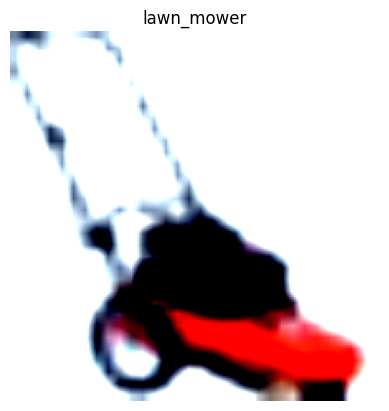

In [16]:
for image_batch, label_batch in train_dataloader:
    img = image_batch[0]
    label = label_batch[0]

    plt.axis("off")
    plt.title(train_dataset.classes[label])
    plt.imshow(img.permute(1, 2, 0));
    break

## Part III. Model

In [17]:
class ResidualBlock(nn.Module):
    def __init__(self, input_channels, output_channels, stride=1):
        super().__init__()
        self.relu = nn.ReLU()
        multiplier = 4
        # bottleneck block built of 3 convs
        self.conv1 = nn.Conv2d(input_channels, output_channels, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(output_channels)
        self.conv2 = nn.Conv2d(output_channels, output_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(output_channels)
        self.conv3 = nn.Conv2d(output_channels, output_channels*multiplier, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn3 = nn.BatchNorm2d(output_channels*4)
        # when using skip connection we also downsample x if needed
        if stride != 1 or input_channels != output_channels * multiplier:
            self.downsample = nn.Sequential(
                nn.Conv2d(input_channels, output_channels * multiplier, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(output_channels * multiplier)
            )
        else:
            self.downsample = None
        
    def forward(self, x):
        identity = x

        f = self.conv1(x)
        f = self.bn1(f)
        f = self.relu(f)

        f = self.conv2(f)
        f = self.bn2(f)
        f = self.relu(f)

        f = self.conv3(f)
        f = self.bn3(f)

        if self.downsample is not None:
            identity = self.downsample(identity)

        h = f + identity
        h = self.relu(h)
        return h

In [18]:
class ResNet50(nn.Module):
    def __init__(self, input_channels=3, num_classes=100):
        super().__init__()
        self.input_channels = 64  # Default
        
        self.ini_conv = nn.Conv2d(input_channels, 64, kernel_size=7, stride=2, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)


        self.layer1 = self.make_layer(64, 3, stride=1)
        self.layer2 = self.make_layer(128, 4, stride=2)
        self.layer3 = self.make_layer(256, 6, stride=2)
        self.layer4 = self.make_layer(512, 3, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4, num_classes)

    def make_layer(self, output_channels, n_blocks, stride):
        layers = []

        layers.append(ResidualBlock(self.input_channels, output_channels, stride=stride))
        self.input_channels = output_channels * 4
        
        for _ in range(1, n_blocks):
            layers.append(ResidualBlock(self.input_channels, output_channels, stride=1))

        return nn.Sequential(*layers)

    def forward(self, X):
        out = self.ini_conv(X)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool(out)

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out

In [19]:
resya = ResNet50()
resya

ResNet50(
  (ini_conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): ResidualBlock(
      (relu): ReLU()
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): Bat

In [20]:
for image_batch, label_batch in train_dataloader:
    logits = resya(image_batch)
    print(logits.shape)
    break

torch.Size([64, 100])


## Part IV. Training

In [29]:
num_classes = 100
num_epochs = 15
learning_rate = 0.00005

model = ResNet50(num_classes=num_classes).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

total_step = len(train_dataloader)

In [30]:
train_step = len(train_dataloader)
val_step = len(val_dataloader)

for epoch in range(num_epochs):
    # Train step
    model.train()
    for i, (images, labels) in enumerate(train_dataloader):
        images = images.to(device)
        labels = labels.to(device)

        logits = model(images)
        outputs = torch.softmax(logits, dim=1).argmax(dim=1)
        loss = loss_fn(logits, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train| Step {i+1}/{train_step}, Loss: {loss.item():.4f}")

    # Validation step
    model.eval()
    with torch.inference_mode():
        correct = 0
        total = 0
        for i, (images, labels) in enumerate(val_dataloader):
            images = images.to(device)
            labels = labels.to(device)
            logits = model(images)

            loss = loss_fn(logits, labels)
            
            _, predicted = torch.max(logits.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del images, labels, logits

        print(f"Val| Step {i+1}/{val_step}, Loss: {loss.item():.4f}, Accuracy: {100*correct/total:.4f}")
        print("="*60)

Epoch 1/15
Train| Step 625/625, Loss: 3.2392
Val| Step 157/157, Loss: 3.5489, Accuracy: 17.2800
Epoch 2/15
Train| Step 625/625, Loss: 2.9441
Val| Step 157/157, Loss: 3.3325, Accuracy: 25.7300
Epoch 3/15
Train| Step 625/625, Loss: 2.7102
Val| Step 157/157, Loss: 2.6367, Accuracy: 33.1600
Epoch 4/15
Train| Step 625/625, Loss: 2.2295
Val| Step 157/157, Loss: 2.9023, Accuracy: 38.3500
Epoch 5/15
Train| Step 625/625, Loss: 2.1105
Val| Step 157/157, Loss: 1.7929, Accuracy: 41.8000
Epoch 6/15
Train| Step 625/625, Loss: 2.5848
Val| Step 157/157, Loss: 1.7887, Accuracy: 46.1000
Epoch 7/15
Train| Step 625/625, Loss: 1.7532
Val| Step 157/157, Loss: 1.7022, Accuracy: 48.7600
Epoch 8/15
Train| Step 625/625, Loss: 1.3688
Val| Step 157/157, Loss: 1.3073, Accuracy: 51.7000
Epoch 9/15
Train| Step 625/625, Loss: 1.0994
Val| Step 157/157, Loss: 2.2070, Accuracy: 51.7000
Epoch 10/15
Train| Step 625/625, Loss: 1.1939
Val| Step 157/157, Loss: 1.6598, Accuracy: 52.0500
Epoch 11/15
Train| Step 625/625, Loss: 